In [135]:
import pandas as pd
import numpy as np 
from hmmlearn import hmm

MAX_STATES = 4 + 1
df = pd.read_csv('energydata_complete.csv')

# Data analysis and split

* We remove the last hour of the entire dataset to have a divisible number of hours.
$$ 
    \frac{\textrm{\# samples} - 7}{144} = 137 Days
$$ = 137 days where 144 is the number of observations in a day. 
* We then split the data into training, validation and test set. 
* We use the first 70% of the data as training set, the next 20% as validation set and the last 10% as test set.

In [136]:
(Dates, Appliances, Lights) = (df.date.to_numpy()[:-7], df.Appliances.to_numpy()[:-7], df.lights.to_numpy()[:-7])

import math

Index = {}
Appliances_X = {}
Lights_X = {}
Dates_X = {}

# Last Index of data to be used for training, validation and testing
Index['train'] = math.ceil(137 * 0.7) * 144
Index['validation'] = math.floor(137 * 0.2) * 144
Index['test'] = math.ceil(137 * 0.1) * 144


# Train data
Appliances_X['train'] = Appliances[:Index['train']]
Lights_X['train'] = Lights[:Index['train']]
Dates_X['train'] = Dates[:Index['train']]

# Validation data
Appliances_X['validation'] = Appliances[Index['train']:Index['train'] + Index['validation']]
Lights_X['validation'] = Lights[Index['train']:Index['train'] + Index['validation']]
Dates_X['validation'] = Dates[Index['train']:Index['train'] + Index['validation']]

# Test data
Appliances_X['test'] = Appliances[Index['train'] + Index['validation']:]
Lights_X['test'] = Lights[Index['train'] + Index['validation']:]
Dates_X['test'] = Dates[Index['train'] + Index['validation']:]

# Concatenated data

In [137]:
# Concatenated Appliances and Lights, and their lengths
Concatenated_X = {}
Lengths_X = {}
Concatenated_X['train'] = np.concatenate((Appliances_X['train'], Lights_X['train']), axis=0)
Concatenated_X['validation'] = np.concatenate((Appliances_X['validation'], Lights_X['validation']), axis=0)
Concatenated_X['test'] = np.concatenate((Appliances_X['test'], Lights_X['test']), axis=0)

Lengths_X['train'] = (len(Appliances_X['train']), len(Lights_X['train']))
Lengths_X['validation'] = (len(Appliances_X['validation']), len(Lights_X['validation']))
Lengths_X['test'] = (len(Appliances_X['test']), len(Lights_X['test']))

## Models creation and training

### For each dataset: Appliances, Lights and the concatenated one, we create a model with 2, 3, 4, 5, 6 hidden states and we train it with the training set created above.

In [138]:
import pickle, os
gHMM = {}
# Dictionary of Models: Gaussian HMM for Concatenated Appliances and Lights
gHMM['Concatenated'] = {}
# Dictionary of Models: Gaussian HMM for Appliances
gHMM['Appliances'] = {}
# Discionary of Models: Gaussian HMM for Lights
gHMM['Lights'] = {}

Recalculate = False

# Gaussian HMM models from 2 to 6 states for Appliances, Lights and thier concatenation
for kind in ['Concatenated', 'Appliances', 'Lights']:
    for i in range(2, MAX_STATES):
        bestModel = {}
        bestScore = {}
        currScore = {}
        if os.path.exists('./models/gHMM_{}_{}.pkl'.format(kind, i)) and not Recalculate:
            gHMM[kind][i] = pickle.load(open('./models/gHMM_{}_{}.pkl'.format(kind, i), 'rb'))
        else:
            for idx in range(50):
                # Gaussian HMM model with i states
                gHMM[kind][i] = hmm.GaussianHMM(n_components=i, covariance_type="diag", random_state=idx, n_iter=1000)
                
                # Fit the model with the training data and calculate the score for the validation data to select the best model
                if kind == 'Concatenated':
                    gHMM[kind][i].fit(Concatenated_X['train'].reshape(-1,1), Lengths_X['train'])
                    currScore[i] = gHMM[kind][i].score(Concatenated_X['validation'].reshape(-1,1), Lengths_X['validation'])
                elif kind == 'Appliances':
                    gHMM[kind][i].fit(Appliances_X['train'].reshape(-1,1))
                    currScore[i] = gHMM[kind][i].score(Appliances_X['validation'].reshape(-1,1))
                elif kind == 'Lights':
                    gHMM[kind][i].fit(Lights_X['train'].reshape(-1,1))
                    currScore[i] = gHMM[kind][i].score(Lights_X['validation'].reshape(-1,1))
            
                # Select the best model (check if the score is better than the previous best score)
                if i not in bestScore or currScore[i] > bestScore[i]:
                    bestScore[i] = currScore[i]
                    bestModel[i] = gHMM[kind][i]
                
            # Save the best model for the current number of states
            gHMM[kind][i] = bestModel[i]
            with open('./models/gHMM_{}_{}.pkl'.format(kind, i), 'wb') as file:
                pickle.dump(gHMM[kind][i], file)
        print('Best Model for {} with {} states : {}'.format(kind, i, gHMM[kind][i]))

Best Model for Concatenated with 2 states : GaussianHMM(n_components=2, n_iter=1000, random_state=49)
Best Model for Concatenated with 3 states : GaussianHMM(n_components=3, n_iter=1000, random_state=45)
Best Model for Concatenated with 4 states : GaussianHMM(n_components=4, n_iter=1000, random_state=3)
Best Model for Appliances with 2 states : GaussianHMM(n_components=2, n_iter=1000, random_state=44)
Best Model for Appliances with 3 states : GaussianHMM(n_components=3, n_iter=1000, random_state=23)
Best Model for Appliances with 4 states : GaussianHMM(n_components=4, n_iter=1000, random_state=9)
Best Model for Lights with 2 states : GaussianHMM(n_components=2, n_iter=1000, random_state=39)
Best Model for Lights with 3 states : GaussianHMM(n_components=3, n_iter=1000, random_state=28)
Best Model for Lights with 4 states : GaussianHMM(n_components=4, n_iter=1000, random_state=34)


In [139]:
# Dictionary of Sequences: Concatenated Appliances and Lights
SConcVal = {}

# Dictionary of Sequences: Appliances
SAppVal = {}

# Dictionary of Sequences: Lights
SLightsVal = {}

for i in range(2, MAX_STATES):
    SConcVal[i] = gHMM['Concatenated'][i].predict(Concatenated_X['validation'].reshape(-1,1), Lengths_X['validation'])
    SAppVal[i] = gHMM['Appliances'][i].predict(Appliances_X['validation'].reshape(-1,1))
    SLightsVal[i] = gHMM['Lights'][i].predict(Lights_X['validation'].reshape(-1,1))
    

## Try to decode the hidden states with the viterbi algorithm 

In [140]:
# Dictionary of Probabilities: Concatenated Appliances and Lights
PConcVal = {}

# Dictionary of Sequences: Concatenated Appliances and Lights
SConcVal = {}

# Dictionary of Probabilities: Appliances
PAppVal = {}

# Dictionary of Sequences: Appliances
SAppVal = {}

# Dictionary of Probabilities: Lights
PLightsVal = {}

# Dictionary of Sequences: Lights
SLightsVal = {}


for i in range(2, MAX_STATES):
    PConcVal[i], SConcVal[i] = gHMM['Concatenated'][i].decode(Concatenated_X['validation'].reshape(-1,1), Lengths_X['validation'], algorithm="viterbi")
    PAppVal[i], SAppVal[i] = gHMM['Appliances'][i].decode(Appliances_X['validation'].reshape(-1,1), algorithm="viterbi")
    PLightsVal[i], SLightsVal[i] = gHMM['Lights'][i].decode(Lights_X['validation'].reshape(-1,1), algorithm="viterbi")

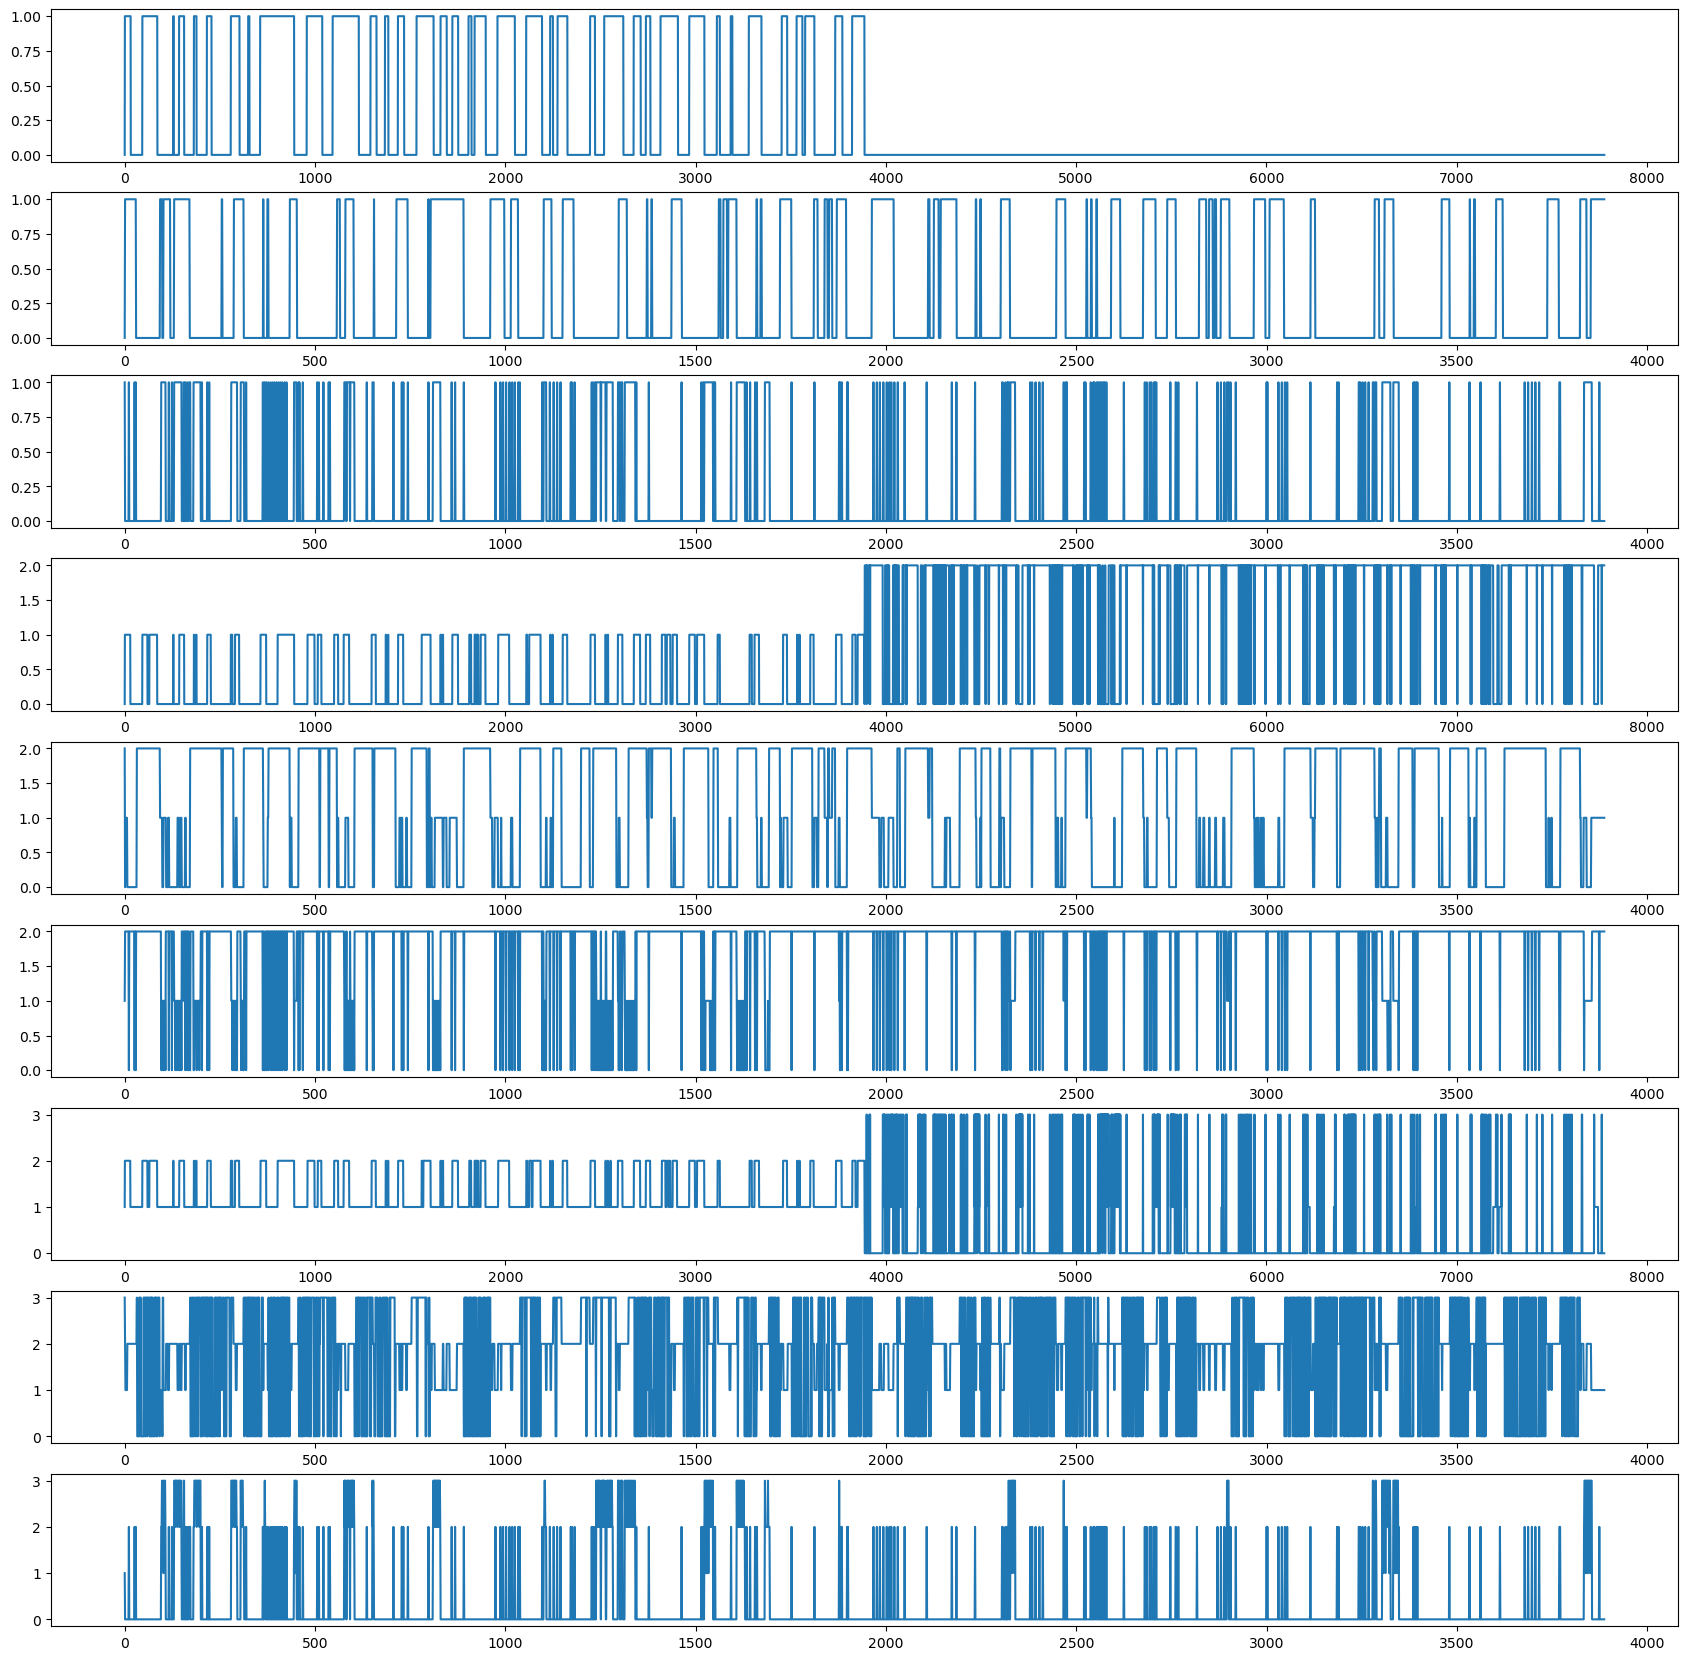

In [141]:
import matplotlib.pyplot as plt
ax = {}

fig, ax = plt.subplots(MAX_STATES*3 - 6, 1, figsize=(21,21))

for i in range(2, MAX_STATES):
    ax[i*3 - 6].plot(SConcVal[i])
    ax[i*3 - 5].plot(SAppVal[i])
    ax[i*3 - 4].plot(SLightsVal[i])
# # sns.lineplot(PAppTrain)
# # sns.lineplot(PLightsTrain, legend='auto')
# PConcTrain
# PConcTrain

In [142]:
X1, Z1 = gHMM['Appliances'][2].sample(Index['test'])

In [143]:
X1 

array([[ 57.15043838],
       [ 45.7345235 ],
       [ 29.46238924],
       ...,
       [ 42.64005324],
       [379.5063219 ],
       [458.67970306]])